##  Download Daytime satellite image.

INPUT:
Google Maps API key
Create download locations from **1marfinal_datatrainig.csv**

OUTPUT:
 satellite images (store in directorygdelt/image/)
We will use the Google Static Maps API to download satellite images.We have to refer Google Static Maps introduction and Google Static Maps API Usage Limits. Must apply for an API key before downloading.

Download the images from Google at zoom level 16 (pixel resolution is about 2.5m).
Set the image size to be 400 pixels X 400 pixels, so that each image downloaded will cover 1 square kilometer.
In this way, each daytime image downloaded will correspond to a single pixel from the nighttime imagery we got from previous steps.

Skip the  Download location generation steps irst two steps if you've already ran them and simply need to continue downloading images.

In [1]:
import math
import random
import os
import numpy as np
import pandas as pd
from osgeo import gdal, osr
from tqdm.notebook import tqdm

import requests
import matplotlib.pyplot as plt
from io import BytesIO
import logging
import time

In [2]:
import time
import os
import os.path
from osgeo import gdal, ogr, osr
from scipy import ndimage, misc
#import cStringIO
from io import StringIO
import io
gdal.UseExceptions()
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
%matplotlib inline
import urllib
import pandas as pd
import numpy as np

# map
import folium
from ipyleaflet import Map, basemaps, basemap_to_tiles
import geopandas
from geopandas import GeoDataFrame
from shapely.geometry import LineString, Point
import contextily

/home/samal/poudelnish/.conda/envs/aanisha/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [3]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
import xgboost as xgb
import seaborn as sns

In [4]:
BASE_DIR = '..'
COUNTRIES_DIR = os.path.join(BASE_DIR, 'gdelt')
PROCESSED_DIR = os.path.join(BASE_DIR, 'data', 'processed')
# can try using the google downloader, in which case change this to be your google api token
ACCESS_TOKEN_DIR = os.path.join(BASE_DIR, 'google_api_key.txt')

RANDOM_SEED = 7 # for reproducibility

# each cluster must have AT LEAST this many images after doing nightlights processing
MIN_IMAGES_PER_CLUSTER = 10



In [5]:
import sys
sys.path.append(BASE_DIR)
from utils import create_space

# Generate Download Locations

In [13]:
df=pd.read_csv('../1marfinal_datatrainig.csv')


In [14]:
df.head()

,Unnamed: 0,long,lat,electricityvalue,elevationvalue,pop15_49,pop0_5,mblphne,nightlights,agvalue,consumervalue,index_num,geometry,index_right,index_protest,pcount,protest_count
0,0,84.594580,28.237083,0.855716,2628.6182,9.000001,2.0,0.889606,0.0,0.764624,0.431688,0,POINT (84.59458160400391 28.23708343505859),0,0,0,1
1,1,84.602910,28.237083,0.833253,2458.8347,12.000000,2.0,0.911913,0.0,0.749635,0.318157,1,POINT (84.60291290283203 28.23708343505859),176,176,0,1
2,2,84.611250,28.237083,0.819445,2207.2593,12.000000,2.0,0.877660,0.0,0.812810,0.400556,2,POINT (84.61125183105469 28.23708343505859),352,352,0,1
3,3,84.619580,28.237083,0.858102,1954.4788,17.000000,4.0,0.861851,0.0,0.907324,0.360631,3,POINT (84.61958312988281 28.23708343505859),528,528,0,1
4,4,84.627914,28.237083,0.943228,1951.0983,22.000000,8.0,0.875475,0.0,0.924259,0.352529,4,POINT (84.62791442871094 28.23708343505859),704,704,0,1


In [15]:
df = df.drop(columns = {"geometry",'Unnamed: 0','index_right','index_protest', 'protest_count'})

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27456 entries, 0 to 27455
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   long              27456 non-null  float64
 1   lat               27456 non-null  float64
 2   electricityvalue  27456 non-null  float64
 3   elevationvalue    27456 non-null  float64
 4   pop15_49          27456 non-null  float64
 5   pop0_5            27456 non-null  float64
 6   mblphne           27456 non-null  float64
 7   nightlights       27456 non-null  float64
 8   agvalue           27456 non-null  float64
 9   consumervalue     27456 non-null  float64
 10  index_num         27456 non-null  int64  
 11  pcount            27456 non-null  int64  
dtypes: float64(10), int64(2)
memory usage: 2.5 MB


In [17]:
df.rename(columns={'lat':'cluster_lat','long':'cluster_lon','pcount':'Noofprotest'},inplace = True)

In [18]:
df.drop(columns=['index_num'], inplace = True)

In [19]:
df.isnull().sum()

cluster_lon         0
cluster_lat         0
electricityvalue    0
elevationvalue      0
pop15_49            0
pop0_5              0
mblphne             0
nightlights         0
agvalue             0
consumervalue       0
Noofprotest         0
dtype: int64

In [20]:
df.loc[df["Noofprotest"] == 0,"Noofprotest"] = np.nan

In [21]:
df.isnull().sum()

cluster_lon             0
cluster_lat             0
electricityvalue        0
elevationvalue          0
pop15_49                0
pop0_5                  0
mblphne                 0
nightlights             0
agvalue                 0
consumervalue           0
Noofprotest         27365
dtype: int64

In [22]:
df = df.dropna()
df

,cluster_lon,cluster_lat,electricityvalue,elevationvalue,pop15_49,pop0_5,mblphne,nightlights,agvalue,consumervalue,Noofprotest
735,85.519585,28.203750,-3.400000e+38,3961.365200,0.000000,0.000000,-3.400000e+38,0.000000,-3.400000e+38,-3.400000e+38,58.0
2121,85.369580,28.128750,9.183422e-01,2541.405000,13.999999,2.000000,8.983536e-01,0.000000,9.513504e-01,2.746843e-01,3.0
2425,85.302920,28.112083,9.694185e-01,1878.762200,98.999990,16.999998,9.329590e-01,0.000000,8.706607e-01,3.476985e-01,26.0
3591,84.619580,28.045416,9.783559e-01,549.689100,67.000000,22.000000,9.788658e-01,0.000000,9.645857e-01,5.748011e-01,4.0
4299,85.319580,28.012083,9.505519e-01,2218.075700,31.000000,6.000000,9.152017e-01,0.000000,9.633982e-01,2.844882e-01,8.0
...,...,...,...,...,...,...,...,...,...,...,...
24169,85.802920,26.953750,1.000000e+00,144.857070,94.000000,18.000000,9.410189e-01,2.100529,7.173164e-01,3.766378e-01,1.0
24481,85.802920,26.937084,9.464660e-01,138.007450,185.000020,34.000004,9.577648e-01,4.400094,7.687278e-01,4.030309e-01,30.0
25109,85.836250,26.903750,9.680011e-01,124.652000,145.000020,28.000002,9.560752e-01,5.357459,7.169570e-01,2.919820e-01,267.0
26038,85.777916,26.853750,8.849816e-01,97.133255,207.000000,38.000000,9.671038e-01,0.000000,7.370859e-01,1.327620e-01,1.0


In [23]:
df.loc[df["electricityvalue"] < 0,"electricityvalue"] = np.nan
df.loc[df["pop15_49"] < 0,"pop15_49"] = np.nan
df.loc[df["pop0_5"] < 0,"pop0_5"] = np.nan
df.loc[df["mblphne"] < 0,"mblphne"] = np.nan
df.loc[df["agvalue"] < 0,"agvalue"] = np.nan
df.loc[df["consumervalue"] < 0,"consumervalue"] = np.nan



In [24]:
df.isnull().sum()

cluster_lon         0
cluster_lat         0
electricityvalue    3
elevationvalue      0
pop15_49            0
pop0_5              0
mblphne             3
nightlights         0
agvalue             2
consumervalue       2
Noofprotest         0
dtype: int64

In [25]:
df["electricityvalue"] = df["electricityvalue"].fillna(0)
df["mblphne"] = df["mblphne"].fillna(0)


In [26]:
df.isnull().sum()

cluster_lon         0
cluster_lat         0
electricityvalue    0
elevationvalue      0
pop15_49            0
pop0_5              0
mblphne             0
nightlights         0
agvalue             2
consumervalue       2
Noofprotest         0
dtype: int64

In [27]:
df.corr()

,cluster_lon,cluster_lat,electricityvalue,elevationvalue,pop15_49,pop0_5,mblphne,nightlights,agvalue,consumervalue,Noofprotest
cluster_lon,1.000000,-0.142161,0.077544,0.226828,0.058927,0.050223,0.070513,0.063240,-0.070897,-0.114659,-0.041981
cluster_lat,-0.142161,1.000000,0.010506,0.736653,0.110181,0.092467,-0.045282,0.079169,0.178635,0.206955,0.047383
electricityvalue,0.077544,0.010506,1.000000,-0.130761,0.137090,0.144305,0.982705,0.172118,-0.132522,0.069862,0.067125
elevationvalue,0.226828,0.736653,-0.130761,1.000000,0.083034,0.066712,-0.184540,0.069026,0.139703,0.137938,0.002105
pop15_49,0.058927,0.110181,0.137090,0.083034,1.000000,0.995238,0.133372,0.839200,-0.566379,0.463398,0.349502
pop0_5,0.050223,0.092467,0.144305,0.066712,0.995238,1.000000,0.142157,0.856237,-0.593166,0.481202,0.348275
mblphne,0.070513,-0.045282,0.982705,-0.184540,0.133372,0.142157,1.000000,0.175599,-0.177838,0.082950,0.080372
nightlights,0.063240,0.079169,0.172118,0.069026,0.839200,0.856237,0.175599,1.000000,-0.768275,0.676316,0.448337
agvalue,-0.070897,0.178635,-0.132522,0.139703,-0.566379,-0.593166,-0.177838,-0.768275,1.000000,-0.725268,-0.302825
consumervalue,-0.114659,0.206955,0.069862,0.137938,0.463398,0.481202,0.082950,0.676316,-0.725268,1.000000,0.236460


In [28]:
df_mw = df.dropna()

In [29]:
df_mw.columns

Index(['cluster_lon', 'cluster_lat', 'electricityvalue', 'elevationvalue',
       'pop15_49', 'pop0_5', 'mblphne', 'nightlights', 'agvalue',
       'consumervalue', 'Noofprotest'],
      dtype='object')

In [30]:
#df_mw.drop(columns={'electricityvalue', 'elevationvalue','pop15_49', 'pop0_5', 'mblphne', 'agvalue'},inplace=True)

In [31]:
df_mw.to_csv("Apr11cleaned.csv",index=False)

In [32]:
df_mw.shape

(89, 11)

In [33]:
df_mw.columns

Index(['cluster_lon', 'cluster_lat', 'electricityvalue', 'elevationvalue',
       'pop15_49', 'pop0_5', 'mblphne', 'nightlights', 'agvalue',
       'consumervalue', 'Noofprotest'],
      dtype='object')

In [34]:
print("Count of location with protest 1 is->",
      df_mw[df_mw['Noofprotest'] == 1]['cluster_lat'].count())
print("Count of location with protest 2 is->",
      df_mw[df_mw['Noofprotest'] == 2]['cluster_lat'].count())
print("Count of location with protest 3 is->",
      df_mw[df_mw['Noofprotest'] == 3]['cluster_lat'].count())
print("Count of location with protest 4 is->",
      df_mw[df_mw['Noofprotest'] >= 4]['cluster_lat'].count())

Count of location with protest 1 is-> 7
Count of location with protest 2 is-> 0
Count of location with protest 3 is-> 5
Count of location with protest 4 is-> 77


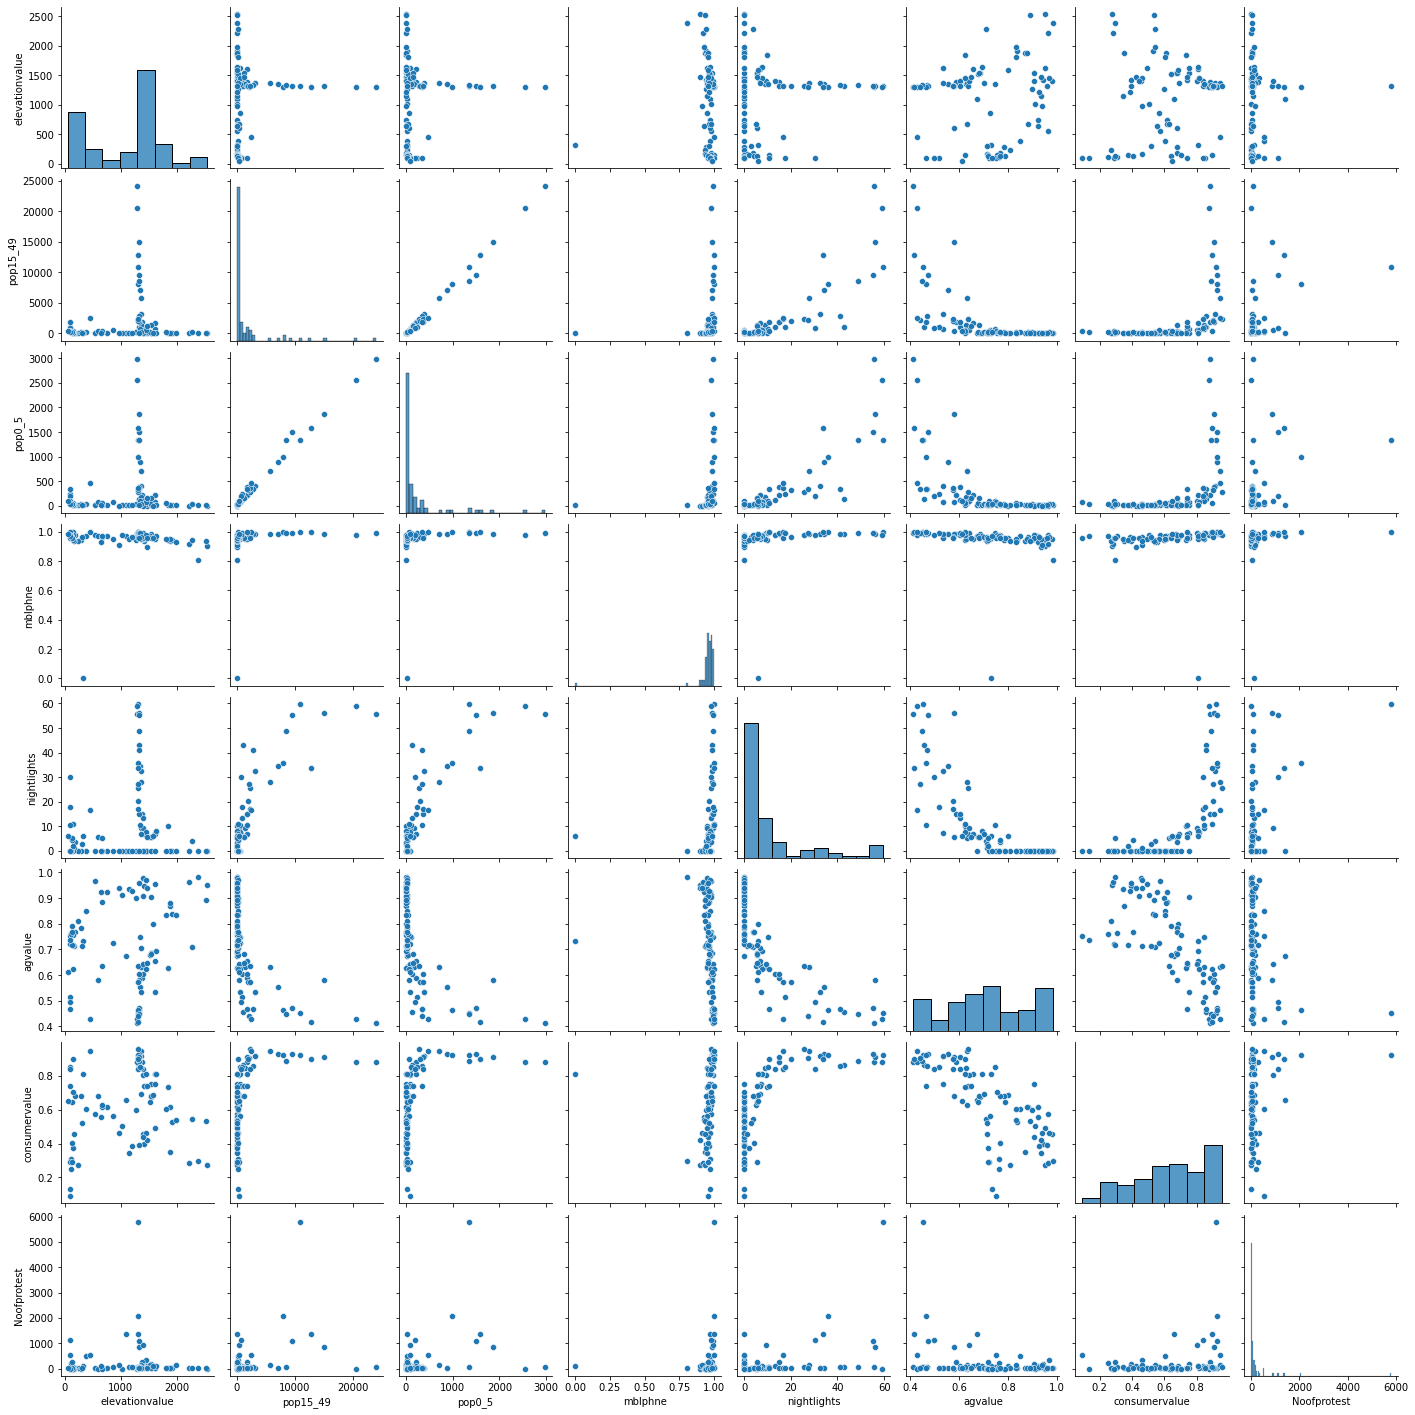

In [35]:
sns.pairplot(df_mw.iloc[:,3:12])

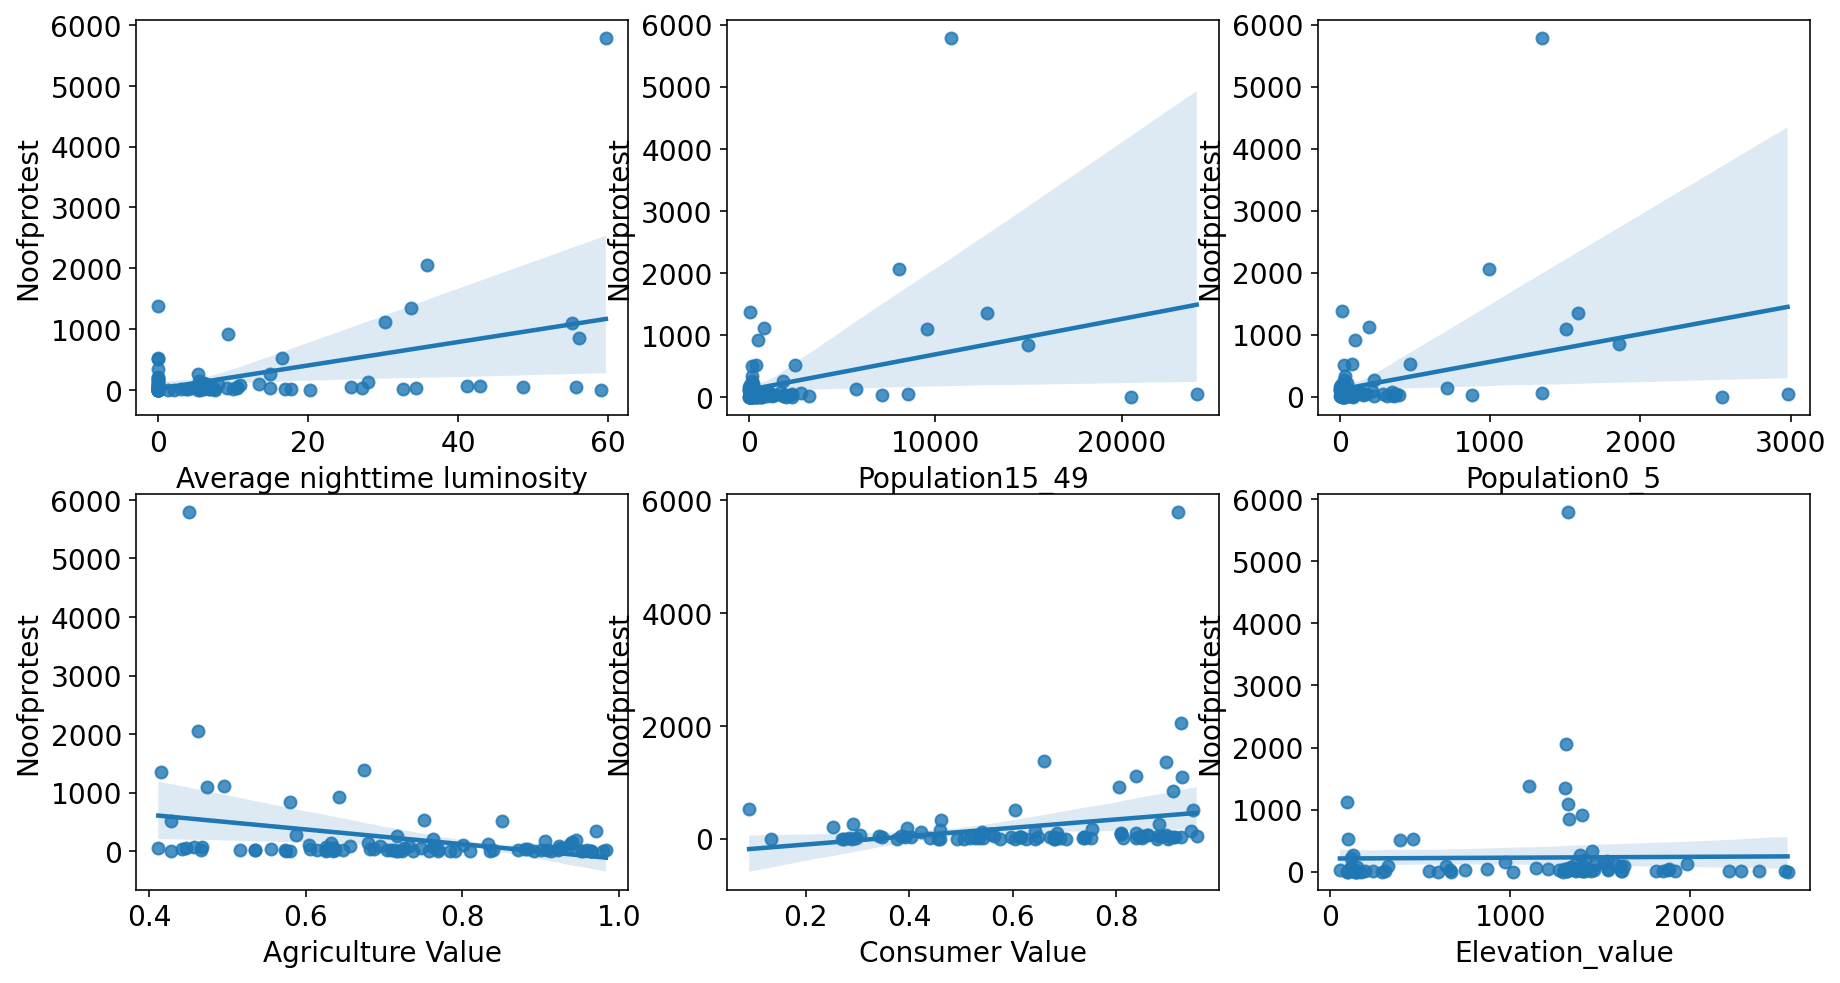

<Figure size 1080x576 with 0 Axes>

In [36]:
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(2, 3, sharex=False, figsize=(15,8))
fig = plt.figure(figsize=(15,8))

%config InlineBackend.figure_format = 'retina'

sns.regplot(x="nightlights", y="Noofprotest", data=df_mw,ax=ax[0][0])
ax[0][0].set_xlabel('Average nighttime luminosity')
ax[0][0].set_ylabel('Noofprotest')

sns.regplot(x="pop15_49", y="Noofprotest", data=df_mw,ax=ax[0][1])
ax[0][1].set_xlabel('Population15_49')
ax[0][1].set_ylabel('Noofprotest')

sns.regplot(x="pop0_5", y="Noofprotest", data=df_mw,ax=ax[0][2])
ax[0][2].set_xlabel('Population0_5')
ax[0][2].set_ylabel('Noofprotest')

sns.regplot(x="agvalue", y="Noofprotest", data=df_mw,ax=ax[1][0])
ax[1][0].set_xlabel('Agriculture Value')
ax[1][0].set_ylabel('Noofprotest')

sns.regplot(x="consumervalue", y="Noofprotest", data=df_mw,ax=ax[1][1])
ax[1][1].set_xlabel('Consumer Value')
ax[1][1].set_ylabel('Noofprotest')

sns.regplot(x="elevationvalue", y="Noofprotest", data=df_mw,ax=ax[1][2])
ax[1][2].set_xlabel('Elevation_value')
ax[1][2].set_ylabel('Noofprotest')


#plt.tight_layout()
plt.show()

Text(0, 0.5, 'No of Protest')

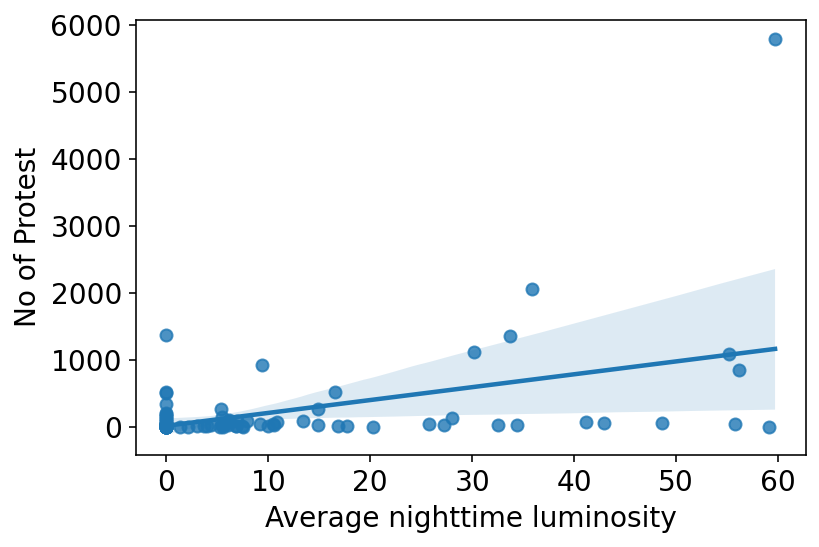

In [37]:
import seaborn as sns
%config InlineBackend.figure_format = 'retina'

ax = sns.regplot(x="nightlights", y="Noofprotest", data=df_mw)
plt.xlabel('Average nighttime luminosity')
plt.ylabel('No of Protest')
#plt.xlim([0, 50])

In [38]:
y_mw = df_mw['Noofprotest'].values
x_mw = df_mw[['nightlights']]


## Baseline Models

In [39]:
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge

data_all = df_mw[['nightlights','Noofprotest']].values
np.random.seed(123)

alphas_list = np.logspace(-1, 5, 7)
final = []
for alpha in alphas_list:
    kf = KFold(n_splits=3, shuffle=True)
    scores = []
    for train_index, test_index in kf.split(data_all):
        reg = Ridge(alpha=alpha)
        train = data_all[train_index]
        test = data_all[test_index]
        reg.fit(train[:, :-1], train[:, -1])
        s = reg.score(test[:, :-1], test[:, -1])
        scores.append(s)
    final.append(np.mean(scores))

print('R^2 of the best model: {:.3f}'.format(np.max(final)))

R^2 of the best model: 0.027


In [40]:
X =df_mw[['electricityvalue', 'elevationvalue',
       'pop15_49', 'pop0_5', 'mblphne', 'nightlights', 'agvalue',
       'consumervalue']]
y= df_mw.Noofprotest

In [41]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [43]:
#Linear Regression
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

lin_regressor=LinearRegression()
mse=cross_val_score(lin_regressor,X,y,scoring='neg_mean_squared_error',cv=5)
mean_mse=np.mean(mse)
print(mean_mse)

-604141.9616111191


In [44]:
lin_regressor.fit(X,y)

LinearRegression()

In [45]:
#Ridge Regression
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

ridge=Ridge()
parameters={'alpha':[1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,20,30,35,40,45,50,55,100]}
ridge_regressor=GridSearchCV(ridge,parameters,scoring='neg_mean_squared_error',cv=5)
ridge_regressor.fit(X,y)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [1e-15, 1e-10, 1e-08, 0.001, 0.01, 1, 5, 10,
                                   20, 30, 35, 40, 45, 50, 55, 100]},
             scoring='neg_mean_squared_error')

In [46]:
print(ridge_regressor.best_params_)
print(ridge_regressor.best_score_)

{'alpha': 45}
-408387.61750505026


In [48]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
lasso=Lasso()
parameters={'alpha':[1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,20,30,35,40,45,50,55,100]}
lasso_regressor=GridSearchCV(lasso,parameters,scoring='neg_mean_squared_error',cv=5)

lasso_regressor.fit(X,y)
print(lasso_regressor.best_params_)
print(lasso_regressor.best_score_)

In [49]:
prediction_lasso=lasso_regressor.predict(X_test)
prediction_ridge=ridge_regressor.predict(X_test)
predict_linear = lin_regressor.predict(X_test)

/home/samal/poudelnish/.conda/envs/aanisha/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Noofprotest', ylabel='Density'>

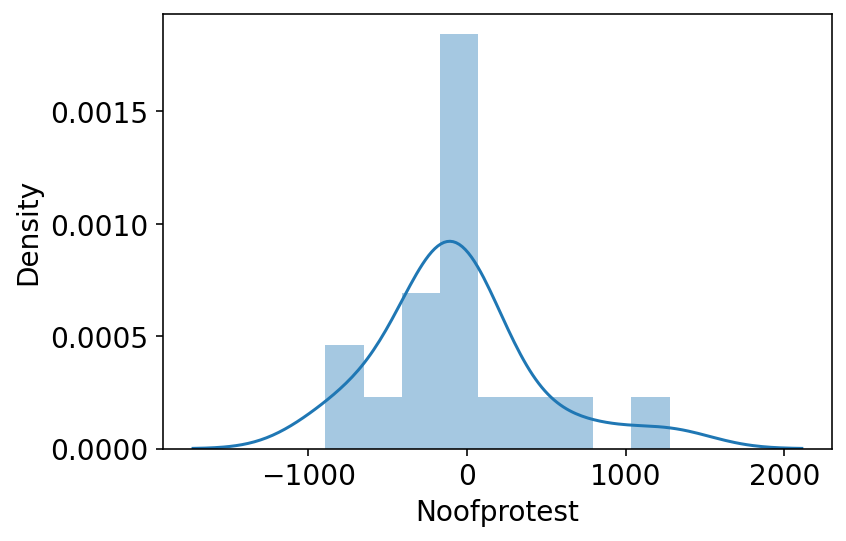

In [50]:
import seaborn as sns

sns.distplot(y_test-prediction_lasso)

/home/samal/poudelnish/.conda/envs/aanisha/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Noofprotest', ylabel='Density'>

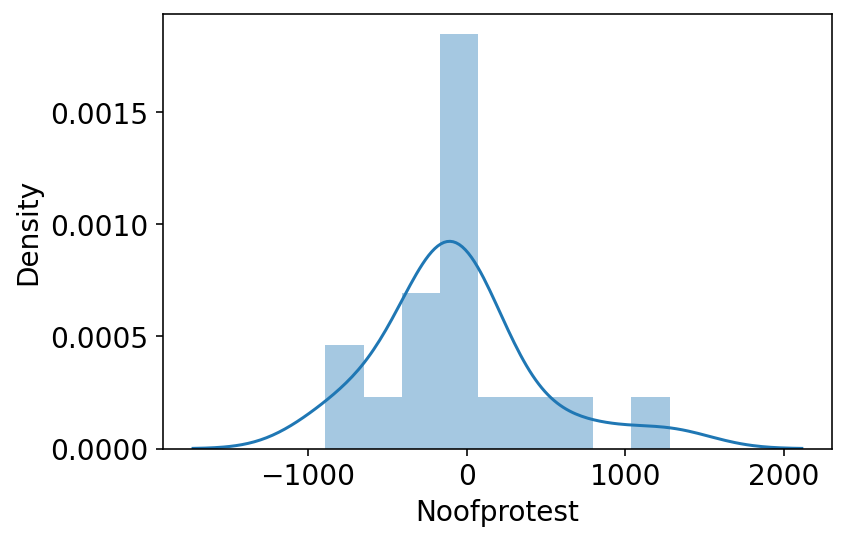

In [51]:
import seaborn as sns

sns.distplot(y_test-prediction_ridge)

/home/samal/poudelnish/.conda/envs/aanisha/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Noofprotest', ylabel='Density'>

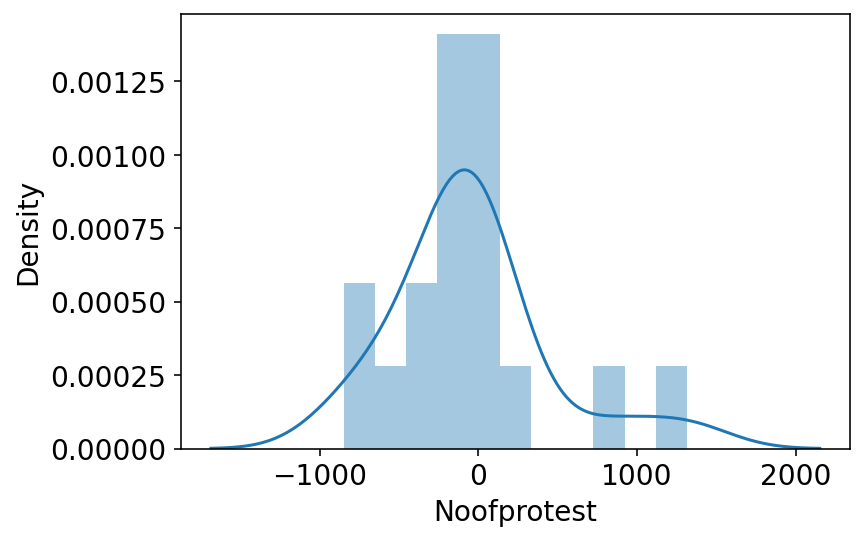

In [52]:
import seaborn as sns

sns.distplot(y_test-predict_linear)

In [53]:
from sklearn.metrics import r2_score
r2_ridge = r2_score(y_test, prediction_ridge)
print('r2 score for ridge  model is', r2_ridge)

r2_lasso = r2_score(y_test, prediction_lasso)
print('r2 score for lass0  model is', r2_lasso)

r2_linear = r2_score(y_test, predict_linear)
print('r2 score for linear  model is', r2_linear)



r2 score for ridge  model is 0.23723628733268476
r2 score for lass0  model is 0.23679009766702042
r2 score for linear  model is 0.23497656259195954


## Generate Download Locations

In [54]:
import math
def generate_download_locations(df, ipc=9):
    '''
    Takes a dataframe with columns cluster_lat, cluster_lon
    Generates a 10km x 10km bounding box around the cluster and samples 
    ipc images per cluster. First samples in a grid fashion, then any 
    remaining points are randomly (uniformly) chosen
    '''
    np.random.seed(RANDOM_SEED) # for reproducability
    df_download = {'image_name': [], 'image_lat': [], 'image_lon': [], 'cluster_lat': [], 
                   'cluster_lon': [], 'consumervalue': [], 'agvalue': [],'elevationvalue':[],'mblphne':[],'pop15_49':[], 'electricityvalue':[] ,'pop0_5':[],'nightlights': [],'Noofprotest': []}
    
    # side length of square for uniform distribution
    edge_num = math.floor(math.sqrt(ipc))
    for _, r in df.iterrows():
        min_lat, min_lon, max_lat, max_lon = create_space(r.cluster_lat, r.cluster_lon)
        lats = np.linspace(min_lat, max_lat, edge_num).tolist()
        lons = np.linspace(min_lon, max_lon, edge_num).tolist()

        # performs cartesian product
        uniform_points = np.transpose([np.tile(lats, len(lons)), np.repeat(lons, len(lats))])
        
        lats = uniform_points[:,0].tolist()
        lons = uniform_points[:,1].tolist()
        
        # fills the remainder with random points
        for _ in range(ipc - edge_num * edge_num):
            lat = random.uniform(min_lat, max_lat)
            lon = random.uniform(min_lon, max_lon)
            lats.append(lat)
            lons.append(lon)
        
        # add to dict
        for lat, lon in zip(lats, lons):
            # image name is going to be image_lat_image_lon_cluster_lat_cluster_lon.png
            image_name = str(lat) + '_' + str(lon) + '_' + str(r.cluster_lat) + '_' + str(r.cluster_lon) + '.png'
            df_download['image_name'].append(image_name)
            df_download['image_lat'].append(lat)
            df_download['image_lon'].append(lon)
            df_download['cluster_lat'].append(r.cluster_lat)
            df_download['cluster_lon'].append(r.cluster_lon)
            df_download['nightlights'].append(r.nightlights)
            df_download['consumervalue'].append(r.consumervalue)
            df_download['agvalue'].append(r.agvalue)
            df_download['elevationvalue'].append(r.elevationvalue)
            df_download['mblphne'].append(r.mblphne)
            df_download['pop15_49'].append(r.pop15_49)
            df_download['electricityvalue'].append(r.electricityvalue)
            df_download['pop0_5'].append(r.pop0_5)
            df_download['Noofprotest'].append(r.Noofprotest)
            
    return pd.DataFrame.from_dict(df_download)




In [55]:
df_mw_download = generate_download_locations(df_mw)


In [56]:
df_mw_download.shape

(801, 14)

In [57]:
df_mw_download.tail()

,image_name,image_lat,image_lon,cluster_lat,cluster_lon,consumervalue,agvalue,elevationvalue,mblphne,pop15_49,electricityvalue,pop0_5,nightlights,Noofprotest
796,26.837084_85.56125_26.837084_85.56125.png,26.837084,85.561250,26.837084,85.56125,0.649576,0.613839,52.4225,0.980307,330.0,0.965833,93.0,6.092529,24.0
797,26.873016611364783_85.56125_26.837084_85.56125...,26.873017,85.561250,26.837084,85.56125,0.649576,0.613839,52.4225,0.980307,330.0,0.965833,93.0,6.092529,24.0
798,26.80115138863522_85.59718261136479_26.837084_...,26.801151,85.597183,26.837084,85.56125,0.649576,0.613839,52.4225,0.980307,330.0,0.965833,93.0,6.092529,24.0
799,26.837084_85.59718261136479_26.837084_85.56125...,26.837084,85.597183,26.837084,85.56125,0.649576,0.613839,52.4225,0.980307,330.0,0.965833,93.0,6.092529,24.0
800,26.873016611364783_85.59718261136479_26.837084...,26.873017,85.597183,26.837084,85.56125,0.649576,0.613839,52.4225,0.980307,330.0,0.965833,93.0,6.092529,24.0


In [58]:
df_mw_download.iat[700,5]

0.30613542

In [59]:
df_mw_download.describe()

,image_lat,image_lon,cluster_lat,cluster_lon,consumervalue,agvalue,elevationvalue,mblphne,pop15_49,electricityvalue,pop0_5,nightlights,Noofprotest
count,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000
mean,27.584649,85.277261,27.584649,85.277261,0.643054,0.714348,1099.611175,0.950683,1859.337122,0.949801,253.662928,10.784730,226.865169
std,0.314269,0.263780,0.312895,0.262141,0.220095,0.166020,652.220397,0.105149,4213.356748,0.106710,534.064925,16.050330,689.937701
min,26.801151,84.583647,26.837084,84.619580,0.090941,0.411820,52.422500,0.000000,13.999999,0.000000,2.000000,0.000000,1.000000
25%,27.501150,85.152916,27.537083,85.152916,0.460698,0.603601,459.999820,0.949893,88.000000,0.946223,17.999998,0.000000,12.000000
50%,27.664683,85.316977,27.662083,85.319580,0.671920,0.715111,1318.371800,0.964112,207.000000,0.968325,34.000004,5.292453,31.000000
75%,27.773016,85.405513,27.762083,85.394585,0.843840,0.870661,1452.603300,0.980196,1281.999900,0.985674,196.000000,13.407218,111.000000
max,28.164683,85.872183,28.128750,85.836250,0.955629,0.983011,2541.405000,0.999553,24019.000000,1.000000,2978.000000,59.707546,5789.000000


# Create Bins for Nightlights 

In [73]:
df_mw_download['nightlights'].max()

59.707546

In [74]:
df_mw_download['nightlights'].min()

0.0

In [75]:
df_mw_download.nightlights.quantile(0.6666) # 33th percentile
#df.consumervalue.quantile(0.66)

7.8999767

In [76]:
print((df_mw_download['nightlights'] <= 0.33).mean())
print((df_mw_download['nightlights'] <= 0.66).mean())
print((df_mw_download['nightlights'] <= 1).mean())


0.42696629213483145
0.42696629213483145
0.42696629213483145


In [78]:
df_mw_download['Noofprotest'].max()

5000.0

In [79]:
print((df_mw_download['nightlights'] <= 1).mean())
print((df_mw_download['nightlights'] <= 2).mean())
print((df_mw_download['nightlights'] <= 3).mean())
print((df_mw_download['nightlights'] <= 4).mean())
print((df_mw_download['nightlights'] >= 5).mean())

0.42696629213483145
0.43820224719101125
0.4606741573033708
0.47191011235955055
0.5056179775280899


In [80]:
print("Count of images with nightlights less than 0 is->",
      df_mw_download[df_mw_download['nightlights'] <= 0.001]['image_name'].count())

print("Count of images with nightlights less than 0.6 is->",
      df_mw_download[df_mw_download['nightlights'] <= 7.89]['image_name'].count())
print("Count of images with nightlights less than 1 is->",
      df_mw_download[df_mw_download['nightlights'] > 7.89]['image_name'].count())




Count of images with nightlights less than 0 is-> 342
Count of images with nightlights less than 0.6 is-> 531
Count of images with nightlights less than 1 is-> 270


In [81]:
df_mw_download.shape

(801, 14)

In [82]:
#df_mw_download.drop(df_mw_download.loc[df_mw_download['nightlights']<=0].index, inplace=True)

array([[<AxesSubplot:title={'center':'nightlights'}>]], dtype=object)

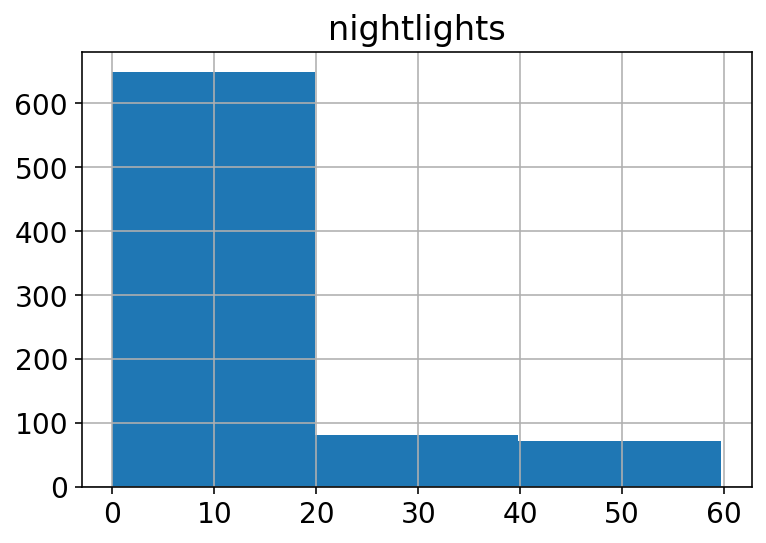

In [83]:
df_mw_download.hist(column='nightlights', bins=3)

In [84]:
# I am going to hand reassign these to have better representation among all three classes
# these are not ideal distributions obviously but the model should still be able to learn
# something like a quantile cut might work better and be less arbitrary, but for reproducability 
# purposes I'll stick to the GMM-based approach

label0_max = 0.001
label1_max = 7.89
label2_max = 62


In [85]:
def query_df(df, lower, upper):
    return df[((lower <= df['nightlights']) & (df['nightlights'] < upper))]

print(len(query_df(df_mw_download, 0, label0_max)) / len(df_mw_download))
print(len(query_df(df_mw_download, label0_max, label1_max)) / len(df_mw_download))
print(len(query_df(df_mw_download, label1_max, label2_max)) / len(df_mw_download))


0.42696629213483145
0.23595505617977527
0.33707865168539325


In [86]:
def create_nightlights_bin(df, cutoffs):
    assert len(cutoffs) >= 2, print('need at least 2 bins')
    cutoffs = sorted(cutoffs, reverse=True)
    labels = list(range(len(cutoffs)))[::-1]
    df['nightlights_bin'] = len(cutoffs)
    for cutoff, label in zip(cutoffs, labels):
        df['nightlights_bin'].loc[df['nightlights'] <= cutoff] = label

df_download = df_mw_download.copy()
create_nightlights_bin(df_download, cutoffs=[label0_max, label1_max, label2_max])

/home/samal/poudelnish/.conda/envs/aanisha/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [88]:
# these should match above
(df_download['nightlights_bin']==0).mean(), (df_download['nightlights_bin']==1).mean(), (df_download['nightlights_bin']==2).mean()


(0.42696629213483145, 0.23595505617977527, 0.33707865168539325)

In [89]:
df_download.shape

(801, 15)

In [90]:
df_download.head()

,image_name,image_lat,image_lon,cluster_lat,cluster_lon,consumervalue,agvalue,elevationvalue,mblphne,pop15_49,electricityvalue,pop0_5,nightlights,Noofprotest,nightlights_bin
0,28.09281738863522_85.33364738863521_28.12875_8...,28.092817,85.333647,28.12875,85.36958,0.274684,0.95135,2541.405,0.898354,13.999999,0.918342,2.0,0.0,3.0,0
1,28.12875_85.33364738863521_28.12875_85.36958.png,28.128750,85.333647,28.12875,85.36958,0.274684,0.95135,2541.405,0.898354,13.999999,0.918342,2.0,0.0,3.0,0
2,28.164682611364782_85.33364738863521_28.12875_...,28.164683,85.333647,28.12875,85.36958,0.274684,0.95135,2541.405,0.898354,13.999999,0.918342,2.0,0.0,3.0,0
3,28.09281738863522_85.36958_28.12875_85.36958.png,28.092817,85.369580,28.12875,85.36958,0.274684,0.95135,2541.405,0.898354,13.999999,0.918342,2.0,0.0,3.0,0
4,28.12875_85.36958_28.12875_85.36958.png,28.128750,85.369580,28.12875,85.36958,0.274684,0.95135,2541.405,0.898354,13.999999,0.918342,2.0,0.0,3.0,0


In [91]:
os.makedirs(PROCESSED_DIR, exist_ok=True)

In [92]:
df_download.to_csv(os.path.join(PROCESSED_DIR, 'nightimage_download_locs.csv'), index=False)

# Download  Daytime Satellite Images
If the script breaks, we  can restart from down onwards.  

It won't download images you have already downloaded.

In [5]:
df_download = pd.read_csv(os.path.join(PROCESSED_DIR, 'nightimage_download_locs.csv'))

In [6]:
# you can try the google downloader if you don't have the planet API key
# the tradeoff is that planet's data can be queried with time, but Google's images
# are higher res
from utils import GoogleDownloader


In [7]:
df_download.head()

,image_name,image_lat,image_lon,cluster_lat,cluster_lon,consumervalue,agvalue,elevationvalue,mblphne,pop15_49,electricityvalue,pop0_5,nightlights,Noofprotest,consumer_bin
0,28.09281738863522_85.33364738863521_28.12875_8...,28.092817,85.333647,28.12875,85.36958,0.274684,0.95135,1.0,0.898354,0.0,0.918342,0.0,0.0,0.0004,0
1,28.12875_85.33364738863521_28.12875_85.36958.png,28.128750,85.333647,28.12875,85.36958,0.274684,0.95135,1.0,0.898354,0.0,0.918342,0.0,0.0,0.0004,0
2,28.164682611364782_85.33364738863521_28.12875_...,28.164683,85.333647,28.12875,85.36958,0.274684,0.95135,1.0,0.898354,0.0,0.918342,0.0,0.0,0.0004,0
3,28.09281738863522_85.36958_28.12875_85.36958.png,28.092817,85.369580,28.12875,85.36958,0.274684,0.95135,1.0,0.898354,0.0,0.918342,0.0,0.0,0.0004,0
4,28.12875_85.36958_28.12875_85.36958.png,28.128750,85.369580,28.12875,85.36958,0.274684,0.95135,1.0,0.898354,0.0,0.918342,0.0,0.0,0.0004,0


In [9]:
'''
To create a download interface to download images from Google's Static Maps API
'''
import math
import requests
import matplotlib.pyplot as plt
#from requests.auth import HTTPBasicAuth
import os
import json
from io import BytesIO
#from shapely.geometry import Polygon

class GoogleDownloader:
    def __init__(self, access_token):
        self.access_token = access_token
        self.url = 'https://maps.googleapis.com/maps/api/staticmap?center={},{}&zoom={}&size=400x400&maptype=satellite&key=*****'
    
    def download(self, lat, long, zoom):
        res = requests.get(self.url.format(lat, long, zoom, self.access_token))
        # server needs to make image available, takes a few seconds
        if res.status_code == 403:
            return 'RETRY'
        assert res.status_code < 400, print(f'Error - failed to download {lat}, {long}, {zoom}')
        image = plt.imread(BytesIO(res.content))
        return image

In [10]:

def download_images(df):
    """
    Download images using a pandas DataFrame that has "image_lat", "image_lon", "image_name" as columns
    
    Saves images to the gdelt/ images folder
    
    """
    access = None
    with open(ACCESS_TOKEN_DIR, 'r') as f:
        access = f.readlines()[0]
    imd = GoogleDownloader(access)
    num_retries = 20
    wait_time = 0.1 # seconds

    # drops what is already downloaded
    already_downloaded = os.listdir(os.path.join(COUNTRIES_DIR, 'images')) 
    already_downloaded =  list(set(already_downloaded).intersection(set(df['image_name'])))
    print('Already downloaded ' + str(len(already_downloaded)))
    df = df.set_index('image_name').drop(already_downloaded).reset_index()
    print('Need to download ' + str(len(df)))
    # use three years of images to find one that matches search critera
    min_year = 2017
    min_month = 1
    max_year = 2019
    max_month = 12
    zoom =16
    for _, r in tqdm(df.iterrows(), total=df.shape[0]):
        lat = r.image_lat
        lon = r.image_lon
        name = r.image_name
        country_dir = None
        
        image_save_path = os.path.join(COUNTRIES_DIR, 'images', r.image_name)
        try:
            im = imd.download(lat, lon,zoom)
            if (type(im) == str and im == 'RETRY') or im is None:
                resolved = False
                for _ in range(num_retries):
                    time.sleep(wait_time)
                    im = imd.download(lat, lon, zoom)
                    
                    if (type(im) == str and im == 'RETRY') or im is None:
                        continue
                    else:
                        plt.imsave(image_save_path, im)
                        resolved = True
                        break
                if not resolved:
                    print(f'Could not download {lat}, {lon} despite several retries and waiting')
                    continue
                else:
                    pass
            else:
                # no issues, save according to naming convention
                plt.imsave(image_save_path, im)

        except Exception as e:
            logging.error(f"Error-could not download {lat}, {lon}", exc_info=True)
            continue

In [11]:
download_images(df_download)

Already downloaded 0
Need to download 801


  0%|          | 0/801 [00:00<?, ?it/s]